In [2]:
import os
import re
from scipy import stats
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.colors import rgb2hex
import pickle as pkl
import sys
sys.path.append('../CEBRA_analysis/')
from dataset_load import data_load
from scipy.stats import mannwhitneyu, normaltest, ttest_ind, levene, ttest_rel


In [3]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]

combos = [[0,2], [0,1], [1,2]]
sl = 0.05
font = 10
w = 0.8

In [4]:
data_dict = data_load(input_folder, variables_to_drop, skipdates, norm=True)


No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [5]:
x_pd = data_dict["X_pd"]
y_pd = data_dict["y_pd"]
animals_id_pd = data_dict["animals_id_pd"]
run_id_pd = data_dict["run_id_pd"]

In [6]:
neu = ['ECOG_LEFT_bursts_high beta_amplitude_mean','ECOG_LEFT_bursts_high gamma_amplitude_mean', 
       'ECOG_LEFT_fft_high beta', 'ECOG_LEFT_fft_high gamma', ]
neu = ['ECOG_LEFT_fft_high beta', 'ECOG_LEFT_fft_high gamma']
neu = ['lshoulder_speed_mean']

In [7]:
df = x_pd#.drop([i for i in x_pd.columns if not i in neu], axis=1)
df["event"] = y_pd
df["animal"] = animals_id_pd

groups_mean = df.groupby(by=["event","animal"]).mean()
groups_mean.reset_index(inplace=True)
groups_mean.drop(["animal"], inplace=True, axis=1)

In [8]:
[i for i in df.columns if "shoulder" in i]

['lshoulder_speed_mean', 'rshoulder_speed_mean']

In [9]:
significant_feats = []
for cond in groups_mean.columns:
    significance = False
    for i, combo in enumerate(combos):
        x1, x2 = combo[0], combo[1]
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]
        pval = ttest_rel(data1, data2).pvalue
        if pval<sl and i==1:
            significance = True
    if significance:
        significant_feats.append(cond)

significant_feats_neu = [i for i in significant_feats if "ECOG" in i]

/home/garullie/.conda/envs/cebra_cuda/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


/tmp/ipykernel_969060/4230622074.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(figsize=(3,3), sharey=True)


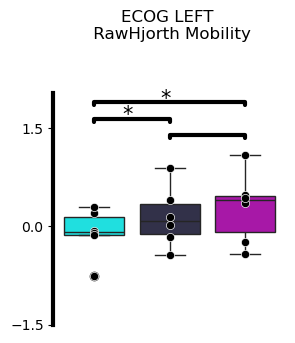

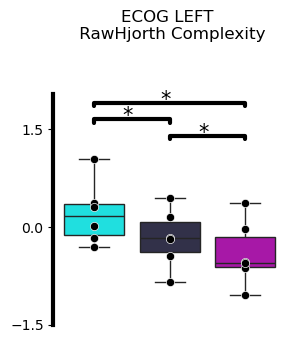

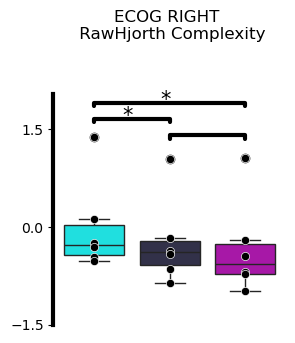

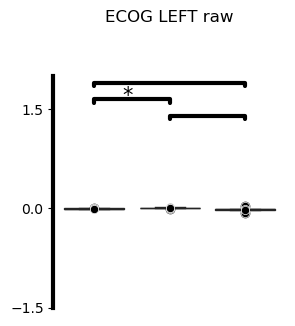

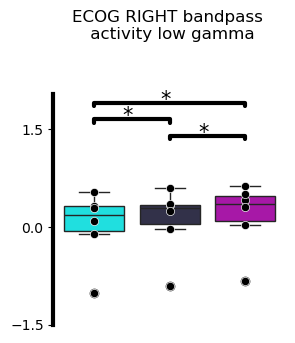

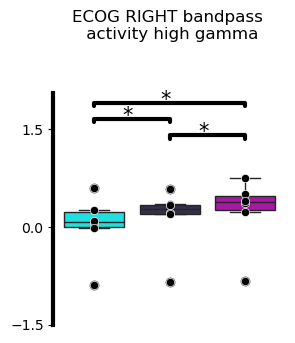

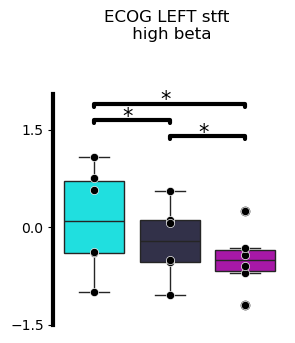

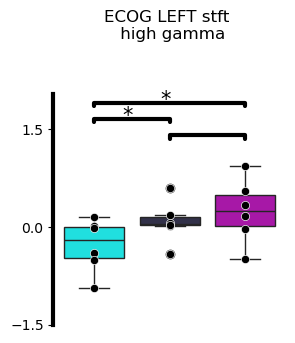

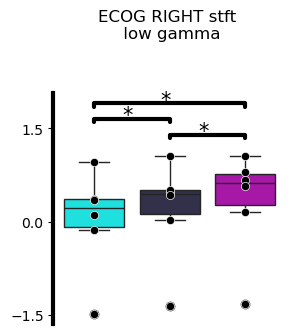

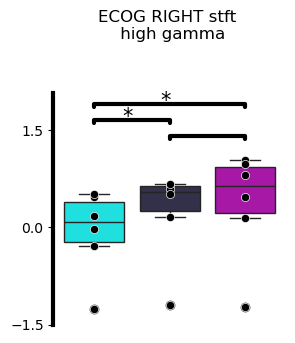

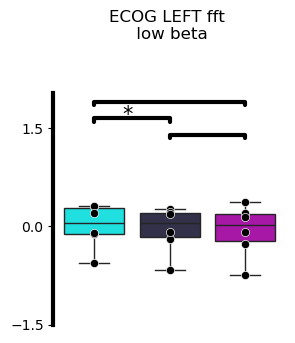

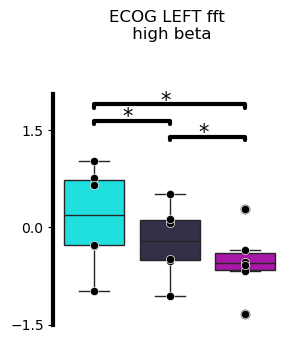

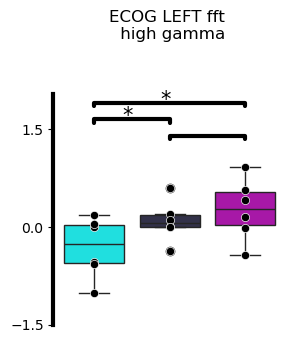

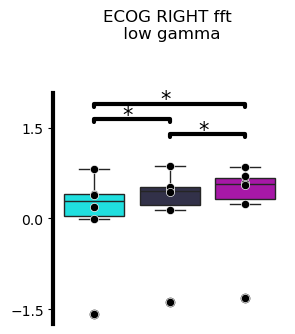

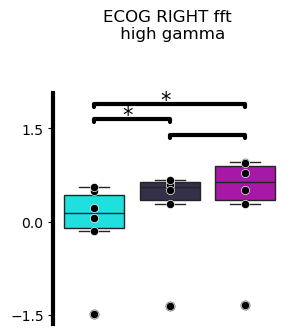

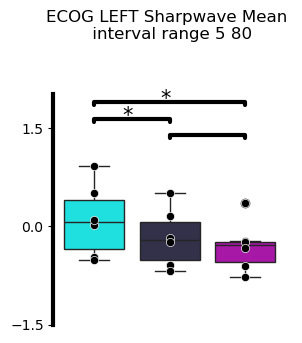

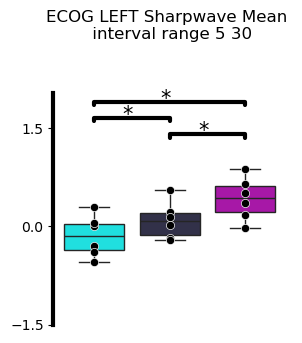

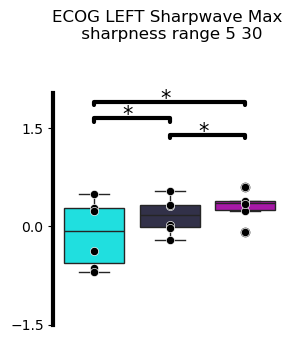

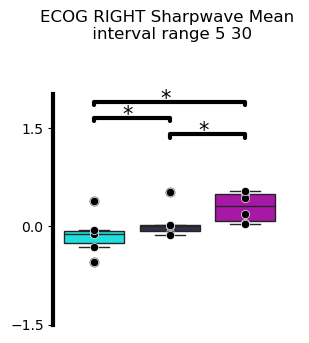

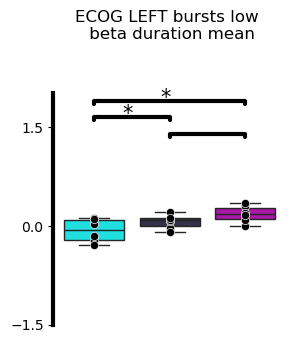

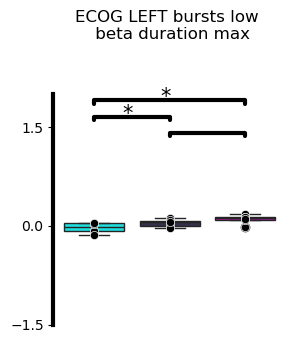

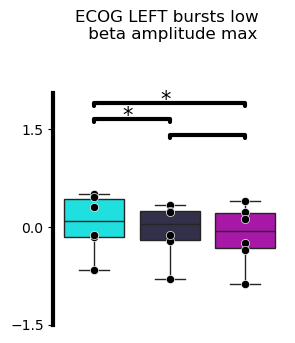

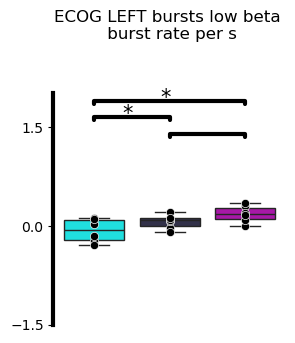

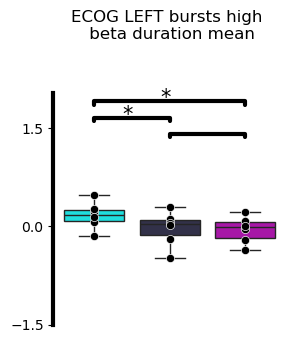

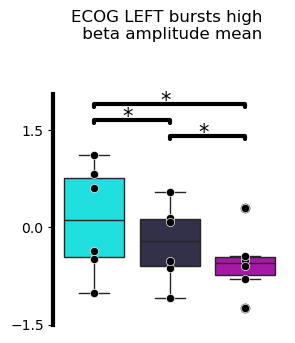

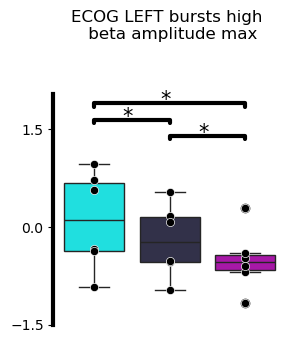

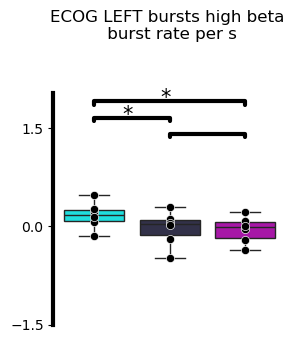

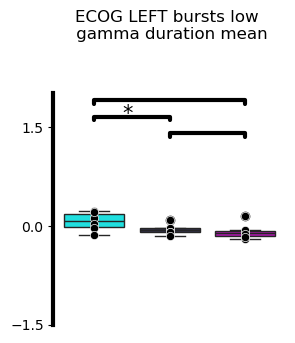

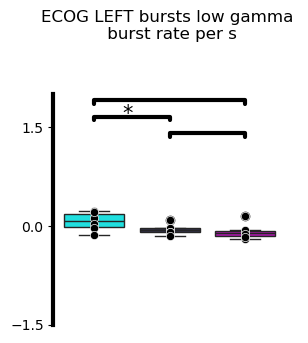

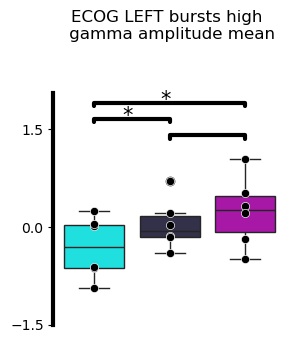

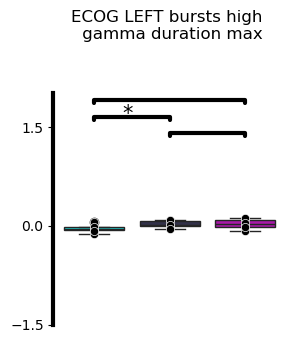

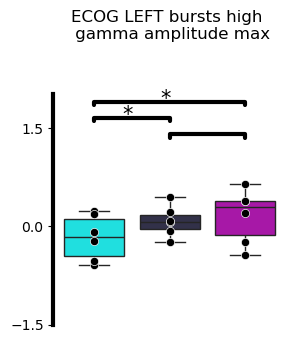

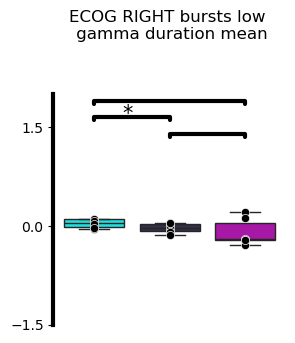

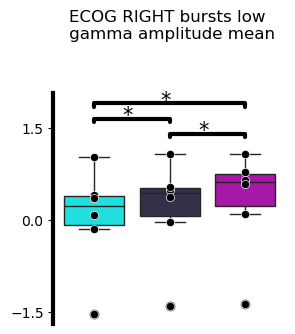

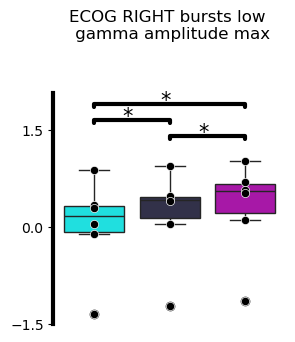

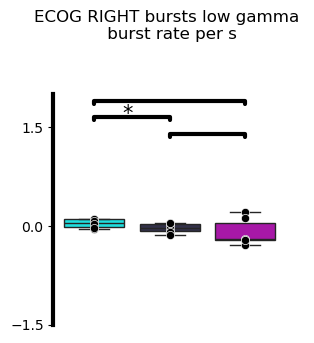

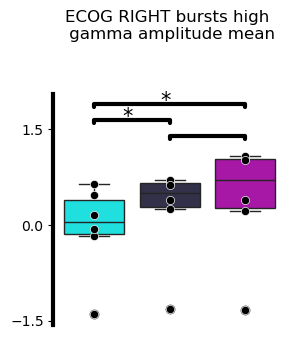

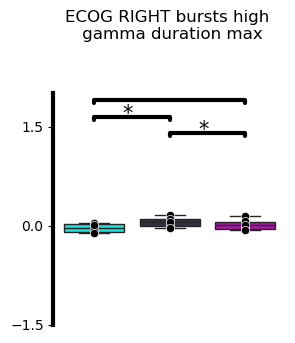

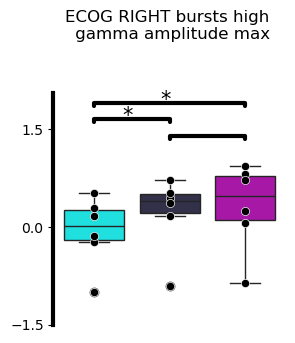

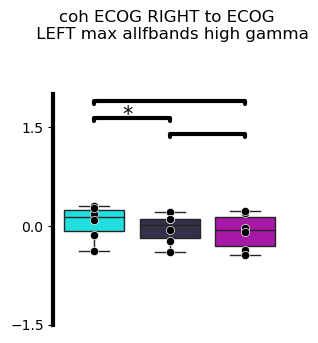

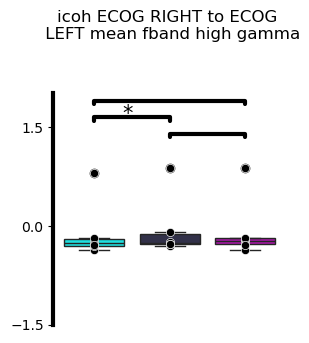

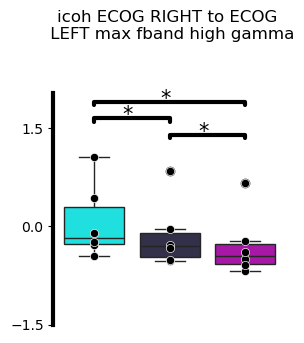

In [13]:
neu = significant_feats_neu
for i, cond in enumerate(neu):
    fig, axs = plt.subplots(figsize=(3,3), sharey=True)
    sns.boxplot(data=groups_mean, y=cond, x="event", hue="event",  ax=axs, palette=["cyan", "#2e2d4d", "m"], legend=False)
    chart = sns.scatterplot(data=groups_mean, y=cond, x="event", ax=axs, color="k", legend=False, s=35, zorder=10)
    
    y = 1.85
    for combo in combos:
        x1, x2 = combo[0], combo[1]
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]
        pval = ttest_rel(data1, data2).pvalue
        significance = "* " if pval<sl else ""
        p = f"p={pval:.2f}" if pval<sl else ""

        h, col = 0.05, 'k'
        chart.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col, solid_capstyle="round")
        chart.text((x1+x2)*.5, y-0.05,  f"{significance}", 
                       ha='center', va='bottom', color=col, fontsize=font+5)
        y-=0.25


    fn = neu[i].replace("_", " ")
    spaces = [m.start() for m in re.finditer(' ', fn)]
    if len(spaces)>2:
        split_space = spaces[int(len(spaces)/2)]
        fn = f"{fn[:split_space]} \n {fn[split_space+1:]}"
    axs.set_title(fn, y=1.2)
    axs.set_ylabel("")
    axs.set_xlabel("")
    axs.set_yticks([-1.5, 0, 1.5])
    axs.set_xticks([])
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.spines['bottom'].set_visible(False)
    axs.spines['left'].set_linewidth(3)

    #plt.savefig(f"./group_comp/{cond}.png", transparent=True)
    #plt.savefig(f"./group_comp/{cond}.svg", transparent=True)

/tmp/ipykernel_494635/2849446167.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
/tmp/ipykernel_494635/2849446167.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)


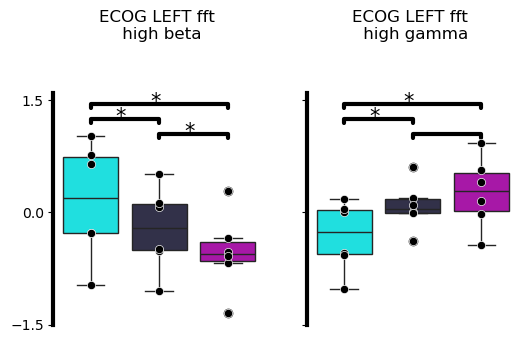

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)
for i in range(2):

    cond = neu[i]
    sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
    chart = sns.scatterplot(data=groups_mean, y=cond, x="event", ax=axs[i], color="k", legend=False, s=35, zorder=10)
    
    y = 1.4
    for combo in combos:
        x1, x2 = combo[0], combo[1]
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]
        pval = ttest_rel(data1, data2).pvalue
        significance = "* " if pval<sl else ""
        p = f"p={pval:.2f}" if pval<sl else ""

        h, col = 0.05, 'k'
        chart.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col, solid_capstyle="round")
        chart.text((x1+x2)*.5, y-0.05,  f"{significance}", 
                       ha='center', va='bottom', color=col, fontsize=font+5)
        y-=0.20


    fn = neu[i].replace("_", " ")
    spaces = [m.start() for m in re.finditer(' ', fn)]
    if len(spaces)>2:
        split_space = spaces[int(len(spaces)/2)]
        fn = f"{fn[:split_space]} \n {fn[split_space+1:]}"
    axs[i].set_title(fn, y=1.2)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_yticks([-1.5, 0, 1.5])
    axs[i].set_xticks([])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_linewidth(3)

plt.savefig("groups_comp_HB_HG.png", transparent=True)
plt.savefig("groups_comp_HB_HG.svg", transparent=True)

/tmp/ipykernel_1057545/2614301160.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
/tmp/ipykernel_1057545/2614301160.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)


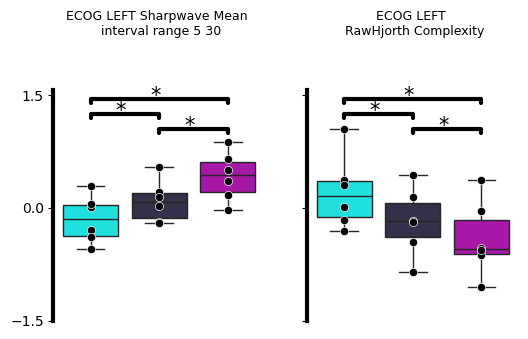

In [21]:
neu = ["ECOG_LEFT_Sharpwave_Mean_interval_range_5_30", "ECOG_LEFT_RawHjorth_Complexity"]
df = x_pd.drop([i for i in x_pd.columns if not i in neu], axis=1)
df["event"] = y_pd
df["animal"] = animals_id_pd

groups_mean = df.groupby(by=["event","animal"]).mean()
groups_mean.reset_index(inplace=True)
#groups_mean.drop(["animal"], inplace=True, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(6,3), sharey=True)
for i in range(2):

    cond = neu[i]
    sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
    chart = sns.scatterplot(data=groups_mean, y=cond, x="event", ax=axs[i], color="k", legend=False, s=35, zorder=10)
    
    y = 1.4
    for combo in combos:
        x1, x2 = combo[0], combo[1]
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]
        pval = ttest_rel(data1, data2).pvalue
        significance = "* " if pval<sl else ""
        p = f"p={pval:.2f}" if pval<sl else ""

        h, col = 0.05, 'k'
        chart.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col, solid_capstyle="round")
        chart.text((x1+x2)*.5, y-0.05,  f"{significance}", 
                       ha='center', va='bottom', color=col, fontsize=font+5)
        y-=0.20


    fn = neu[i].replace("_", " ")
    spaces = [m.start() for m in re.finditer(' ', fn)]
    if len(spaces)>2:
        split_space = spaces[int(len(spaces)/2)]
        fn = f"{fn[:split_space]} \n {fn[split_space+1:]}"
    axs[i].set_title(fn, y=1.2, fontsize=9)
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].set_yticks([-1.5, 0, 1.5])
    axs[i].set_xticks([])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)
    axs[i].spines['left'].set_linewidth(3)

plt.savefig("groups_comp_new_neural_feat.png", transparent=True)
plt.savefig("groups_comp_new_neural_feat.svg", transparent=True)

/tmp/ipykernel_476116/2324314568.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
/tmp/ipykernel_476116/2324314568.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
/tmp/ipykernel_476116/2324314568.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
/tmp

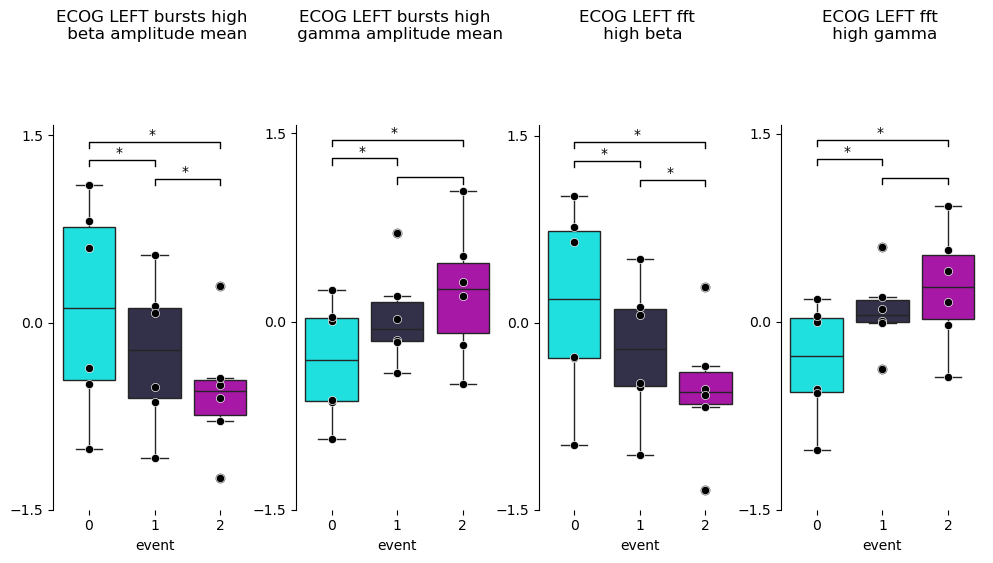

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(12,5))
for i in range(4):

    cond = neu[i]
    sns.boxplot(data=groups_mean, y=cond, x="event", ax=axs[i], palette=["cyan", "#2e2d4d", "m"], legend=False)
    chart = sns.scatterplot(data=groups_mean, y=cond, x="event", ax=axs[i], color="k", legend=False, s=35, zorder=10)
    
    y = 1.4
    for combo in combos:
        x1, x2 = combo[0], combo[1]
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]
        pval = ttest_rel(data1, data2).pvalue
        significance = "* " if pval<sl else ""
        p = f"p={pval:.2f}" if pval<sl else ""

        h, col = 0.05, 'k'
        chart.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        chart.text((x1+x2)*.5, y+h,  f"{significance}", 
                       ha='center', va='bottom', color=col, fontsize=font)
        y-=0.15


    fn = neu[i].replace("_", " ")
    spaces = [m.start() for m in re.finditer(' ', fn)]
    if len(spaces)>2:
        split_space = spaces[int(len(spaces)/2)]
        fn = f"{fn[:split_space]} \n {fn[split_space+1:]}"
    axs[i].set_title(fn, y=1.2)
    axs[i].set_ylabel("")
   # axs[i].set_ylim(-1.1, 1.1)
    axs[i].set_yticks(axs[i].get_yticks()[::3])
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['bottom'].set_visible(False)

In [15]:
for i in range(4):
    cond = neu[i]

    for combo in combos:
        data1 = groups_mean[cond][groups_mean["event"]==combo[0]]
        data2 = groups_mean[cond][groups_mean["event"]==combo[1]]

        sh_data1 = stats.shapiro(data1)
        sh_data2 = stats.shapiro(data2)
        normal = "no"
        eq_var = "no"
        if sh_data1.pvalue > sl and sh_data2.pvalue > sl:
            normal = "yes"
            # Normally distributed data
            levene_test = levene(data1, data2)
            if levene_test.pvalue > sl:
                # equal variance
                pval = ttest_ind(data1, data2).pvalue
                test = "Student's t-test"
                eq_var = "yes"
            else:
                # Unequal variance
                pval = ttest_ind(data1, data2, equal_var=False).pvalue
                test = "Welch’s t-test"
        else:
            pval = mannwhitneyu(data1, data2).pvalue
            test = "Mann Whitney u-test"

        print(f"{cond} states: {[i for i in combo]}, normal: {normal}, eq var: {eq_var}, pval={pval}")
   


ECOG_LEFT_bursts_high beta_amplitude_mean states: [0, 2], normal: yes, eq var: yes, pval=0.13236542209249408
ECOG_LEFT_bursts_high beta_amplitude_mean states: [0, 1], normal: yes, eq var: yes, pval=0.41767768749468637
ECOG_LEFT_bursts_high beta_amplitude_mean states: [1, 2], normal: yes, eq var: yes, pval=0.3700350400847492
ECOG_LEFT_bursts_high gamma_amplitude_mean states: [0, 2], normal: yes, eq var: yes, pval=0.0899145350610625
ECOG_LEFT_bursts_high gamma_amplitude_mean states: [0, 1], normal: yes, eq var: yes, pval=0.18727097039247867
ECOG_LEFT_bursts_high gamma_amplitude_mean states: [1, 2], normal: yes, eq var: yes, pval=0.4840638727651302
ECOG_LEFT_fft_high beta states: [0, 2], normal: yes, eq var: yes, pval=0.10540804730523158
ECOG_LEFT_fft_high beta states: [0, 1], normal: yes, eq var: yes, pval=0.36075122026908324
ECOG_LEFT_fft_high beta states: [1, 2], normal: yes, eq var: yes, pval=0.35448860018590034
ECOG_LEFT_fft_high gamma states: [0, 2], normal: yes, eq var: yes, pval=0